<a href="https://colab.research.google.com/github/VUT-BA-3-2-Project-2025/Team-force/blob/main/Team_Force_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TEAM FORCE - BUSINESS ANALYSIS 3.2 PROJECT: AI DEMAND FORECASTING MODEL

In [13]:
#import all the necessary libraries for our project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [3]:
logistics_df = pd.read_csv("https://raw.githubusercontent.com/VUT-BA-3-2-Project-2025/Team-force/main/logistics_dataset.csv")
logistics_df.head()

,item_id,category,stock_level,reorder_point,reorder_frequency_days,lead_time_days,daily_demand,demand_std_dev,item_popularity_score,storage_location_id,...,unit_price,holding_cost_per_unit_day,stockout_count_last_month,order_fulfillment_rate,total_orders_last_month,turnover_ratio,layout_efficiency_score,last_restock_date,forecasted_demand_next_7d,KPI_score
0,ITM10000,Pharma,283,21,4,4,49.85,1.56,0.43,L82,...,117.80,1.14,0,0.80,700,3.33,0.33,2024-02-17,184.37,0.556
1,ITM10001,Automotive,301,52,9,6,23.34,2.55,0.69,L15,...,178.80,1.09,3,0.79,736,10.36,0.98,2024-10-01,221.94,0.723
2,ITM10002,Groceries,132,60,11,8,37.69,3.15,0.62,L4,...,54.05,0.95,7,0.75,814,14.32,0.87,2024-04-07,53.85,0.680
3,ITM10003,Automotive,346,46,13,5,33.69,2.79,0.21,L95,...,31.10,1.90,0,0.96,994,2.08,0.29,2024-01-27,92.04,0.488
4,ITM10004,Automotive,49,55,4,6,49.58,5.23,0.31,L36,...,104.97,0.63,5,0.83,299,5.65,0.96,2024-05-17,194.58,0.670


In [11]:
#Starting Exploratory Data Analysis EDA
logistics_df.describe()

,stock_level,reorder_point,reorder_frequency_days,lead_time_days,daily_demand,demand_std_dev,item_popularity_score,picking_time_seconds,handling_cost_per_unit,unit_price,holding_cost_per_unit_day,stockout_count_last_month,order_fulfillment_rate,total_orders_last_month,turnover_ratio,layout_efficiency_score,forecasted_demand_next_7d,KPI_score
count,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000,3204.000000
mean,263.491573,54.759363,8.507803,5.578340,25.435868,5.260078,0.542325,95.606429,2.777116,105.887575,1.045993,4.602372,0.849738,521.714732,8.123677,0.600581,154.286245,0.601737
std,138.568360,26.053354,3.473229,2.292486,14.038861,2.725639,0.259200,49.218084,1.305213,54.428161,0.550480,2.883708,0.086703,276.768531,4.069191,0.230511,82.945255,0.108286
min,20.000000,10.000000,3.000000,2.000000,1.010000,0.500000,0.100000,10.000000,0.500000,10.220000,0.100000,0.000000,0.700000,50.000000,1.000000,0.200000,10.090000,0.259000
25%,144.000000,32.000000,5.000000,4.000000,13.535000,2.917500,0.310000,53.000000,1.660000,59.760000,0.580000,2.000000,0.780000,283.000000,4.590000,0.400000,83.190000,0.527000
50%,264.000000,55.000000,9.000000,6.000000,25.405000,5.235000,0.540000,96.000000,2.810000,106.005000,1.050000,5.000000,0.850000,513.500000,8.150000,0.600000,152.870000,0.601000
75%,386.000000,78.000000,12.000000,8.000000,37.412500,7.542500,0.760000,138.000000,3.910000,152.410000,1.522500,7.000000,0.920000,764.250000,11.692500,0.800000,225.440000,0.677250
max,499.000000,99.000000,14.000000,9.000000,49.980000,10.000000,1.000000,179.000000,5.000000,200.000000,2.000000,9.000000,1.000000,999.000000,15.000000,1.000000,299.940000,0.936000


In [12]:
logistics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3204 entries, 0 to 3203
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   item_id                    3204 non-null   object 
 1   category                   3204 non-null   object 
 2   stock_level                3204 non-null   int64  
 3   reorder_point              3204 non-null   int64  
 4   reorder_frequency_days     3204 non-null   int64  
 5   lead_time_days             3204 non-null   int64  
 6   daily_demand               3204 non-null   float64
 7   demand_std_dev             3204 non-null   float64
 8   item_popularity_score      3204 non-null   float64
 9   storage_location_id        3204 non-null   object 
 10  zone                       3204 non-null   object 
 11  picking_time_seconds       3204 non-null   int64  
 12  handling_cost_per_unit     3204 non-null   float64
 13  unit_price                 3204 non-null   float

In [9]:
# Convert date column to datetime objects
logistics_df['last_restock_date'] = pd.to_datetime(logistics_df['last_restock_date'])

In [13]:
logistics_df.isnull().sum()

,0
item_id,0
category,0
stock_level,0
reorder_point,0
reorder_frequency_days,0
lead_time_days,0
daily_demand,0
demand_std_dev,0
item_popularity_score,0
storage_location_id,0


In [7]:
# Count unique values for each column
for col in logistics_df.columns:
    print(f"number of unique values in '{col}' is {logistics_df[col].nunique()}")

number of unique values in 'item_id' is 3204
number of unique values in 'category' is 5
number of unique values in 'stock_level' is 479
number of unique values in 'reorder_point' is 90
number of unique values in 'reorder_frequency_days' is 12
number of unique values in 'lead_time_days' is 8
number of unique values in 'daily_demand' is 2375
number of unique values in 'demand_std_dev' is 910
number of unique values in 'item_popularity_score' is 91
number of unique values in 'storage_location_id' is 100
number of unique values in 'zone' is 4
number of unique values in 'picking_time_seconds' is 170
number of unique values in 'handling_cost_per_unit' is 451
number of unique values in 'unit_price' is 2962
number of unique values in 'holding_cost_per_unit_day' is 191
number of unique values in 'stockout_count_last_month' is 10
number of unique values in 'order_fulfillment_rate' is 31
number of unique values in 'total_orders_last_month' is 922
number of unique values in 'turnover_ratio' is 125

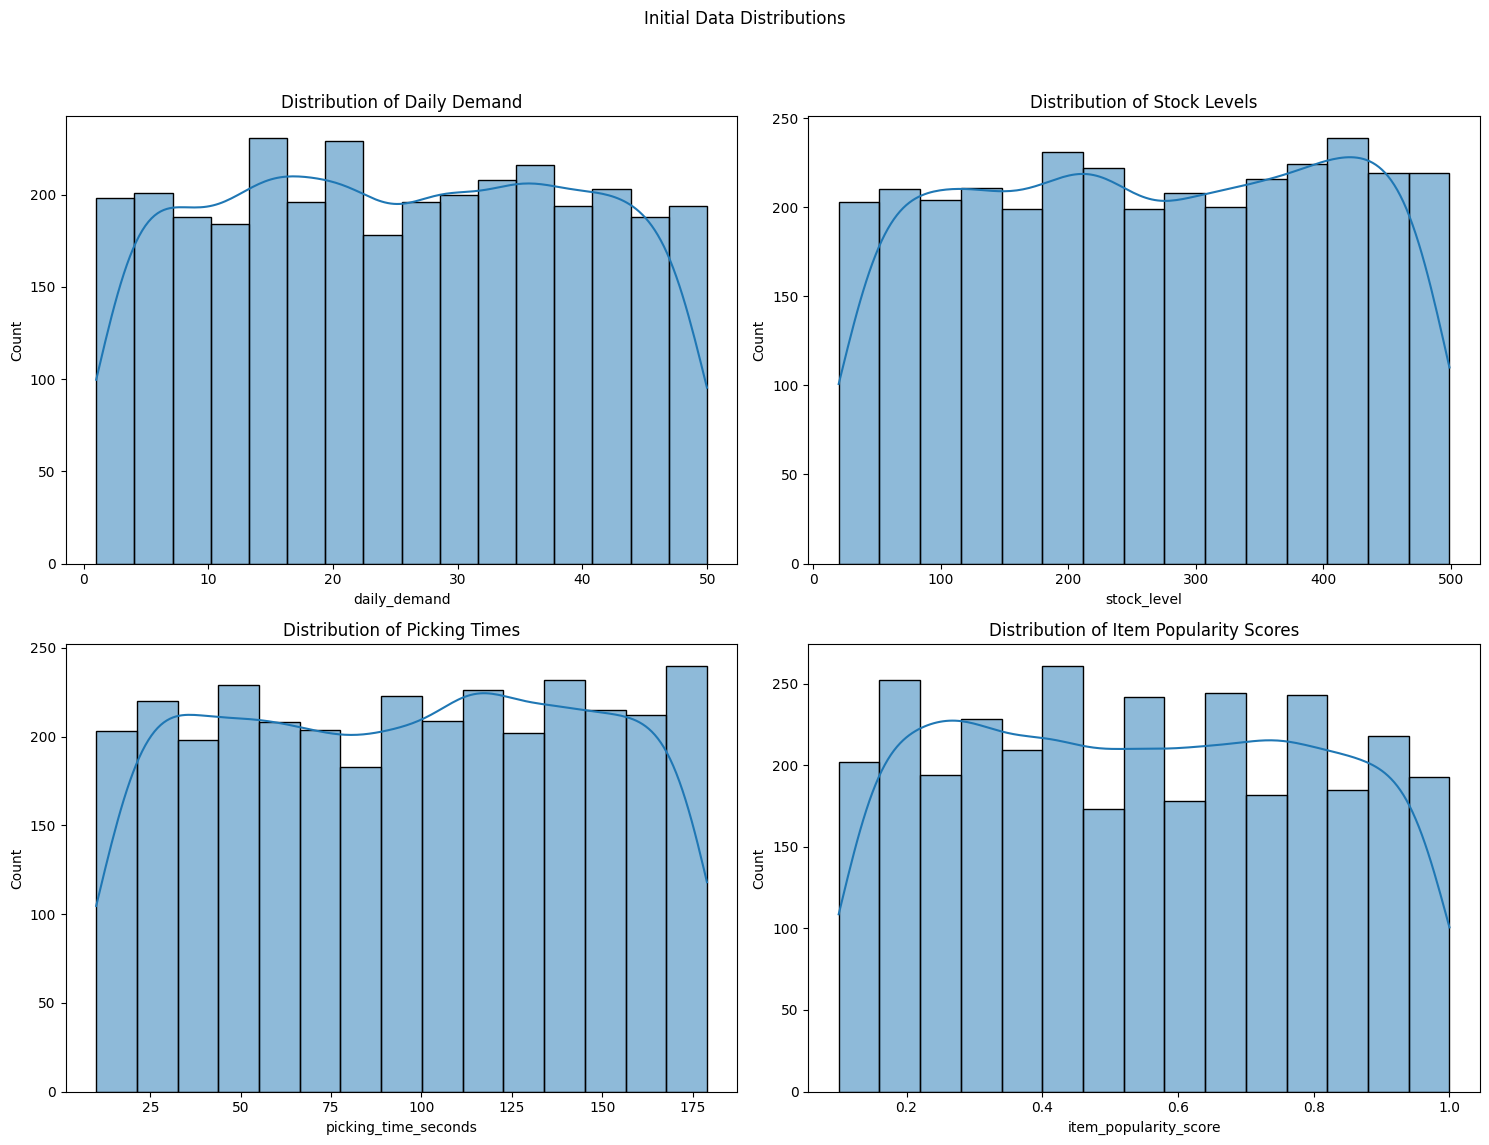

In [8]:
#Visualize our dataset to find patterns
plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
sns.histplot(logistics_df['daily_demand'], kde=True)
plt.title('Distribution of Daily Demand')
plt.subplot(2, 2, 2)
sns.histplot(logistics_df['stock_level'], kde=True)
plt.title('Distribution of Stock Levels')
plt.subplot(2, 2, 3)
sns.histplot(logistics_df['picking_time_seconds'], kde=True)
plt.title('Distribution of Picking Times')
plt.subplot(2, 2, 4)
sns.histplot(logistics_df['item_popularity_score'], kde=True)
plt.title('Distribution of Item Popularity Scores')
plt.suptitle('Initial Data Distributions')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

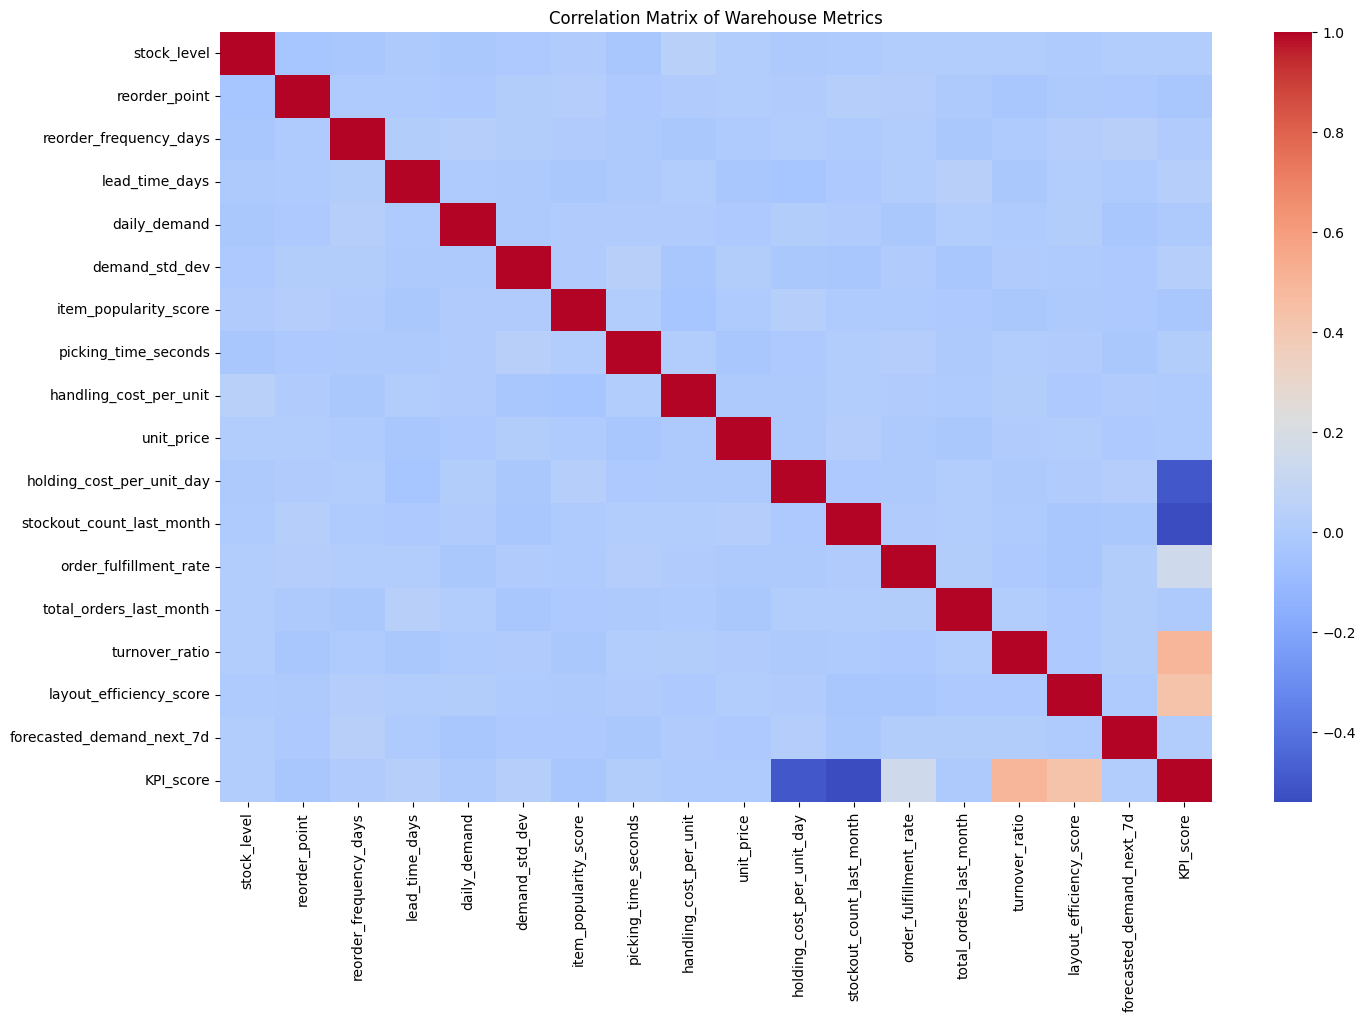

In [15]:
# # Visualization 2: Correlation Heatmap to see relationships between variables
plt.figure(figsize=(16, 10))
numeric_cols = logistics_df.select_dtypes(include=np.number).columns
sns.heatmap(logistics_df[numeric_cols].corr(), cmap='coolwarm')
plt.title('Correlation Matrix of Warehouse Metrics')
plt.show()

Time series created successfully. Shape: (365,)

Step 2: Smoothing data with a 7-day rolling average...
Data smoothed. New shape: (359,)

Step 3: Preparing Data for LSTM Model...
Data split sequentially: 276 training samples, 69 testing samples.

Step 4: Building and Training the Deep Learning (LSTM) Model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 14, 150)        │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,951 (1.04 MB)

 Trainable params: 271,951 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.1671
Epoch 2/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0446
Epoch 3/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0338
Epoch 4/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0279
Epoch 5/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0295
Epoch 6/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0265
Epoch 7/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0266
Epoch 8/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0252
Epoch 9/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0229
Epoch 10/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0194
Epoch 11/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0204
Epoch 12/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0169
Epoch 13/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0182
Epoch 14/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0190
Epoch 15/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0152
Epoch 16/150
9/9 ━━

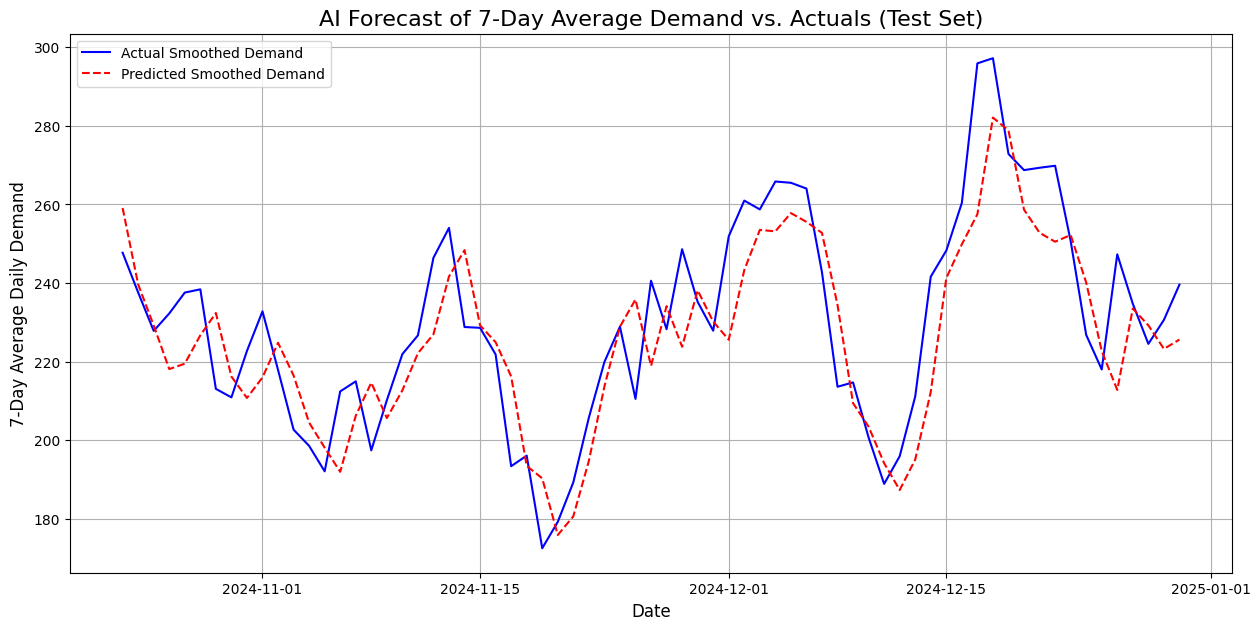

In [11]:
daily_demand_series = logistics_df.groupby('last_restock_date')['daily_demand'].sum()

daily_demand_series = daily_demand_series.asfreq('D', fill_value=0)
print("Time series created successfully. Shape:", daily_demand_series.shape)

daily_demand_smoothed = daily_demand_series.rolling(window=7).mean().dropna()
print("Data smoothed. New shape:", daily_demand_smoothed.shape)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(daily_demand_smoothed.values.reshape(-1, 1))

timesteps = 14
X, y = [], []
for i in range(len(scaled_data) - timesteps):
    X.append(scaled_data[i:(i + timesteps), 0])
    y.append(scaled_data[i + timesteps, 0])
X, y = np.array(X), np.array(y)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split the data.
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f"Data split sequentially: {len(X_train)} training samples, {len(X_test)} testing samples.")

model = Sequential([
    LSTM(units=150, return_sequences=True, input_shape=(X.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=150),
    Dropout(0.2),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

history = model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=1)
print("Model training complete.")

predictions_scaled = model.predict(X_test)

predictions = scaler.inverse_transform(predictions_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
print(f"RMSE: {rmse:.2f}")

# Plot the results
plt.figure(figsize=(15, 7))
plt.plot(daily_demand_smoothed.index[-len(y_test_actual):], y_test_actual, color='blue', label='Actual Smoothed Demand')
plt.plot(daily_demand_smoothed.index[-len(predictions):], predictions, color='red', linestyle='--', label='Predicted Smoothed Demand')
plt.title('AI Forecast of 7-Day Average Demand vs. Actuals (Test Set)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('7-Day Average Daily Demand', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [14]:
nlp_df = pd.read_csv("NLP 1.1.1.csv")

# Step 1.2: Define our input (X) and our target (y)
# X is the column with the text we want to analyze
X = nlp_df['Text Data']
# y is the column with the correct answer (the demand change category)
y = nlp_df['Associated Demand Change ']

# Step 1.3: Split the data into a training set and a testing set.
# The model will learn from the training set and be evaluated on the unseen testing set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(f"Data split into {len(X_train)} training samples and {len(X_test)} testing samples.")


# --- PART 2: BUILD AND TRAIN THE NLP MODEL ---

print("\n--- PART 2: Building and Training the NLP Model ---")
# Step 2.1: Create the machine learning pipeline.
# This pipeline defines the two steps our AI will perform:
# 1. 'tfidf': First, it will take the raw text and convert it into numerical TF-IDF vectors.
# 2. 'clf': Second, it will feed those vectors into our LinearSVC classifier to learn the patterns.
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC()),
])

# Step 2.2: Train the model.
# The .fit() command tells our pipeline to learn from the training data.
# It will learn the vocabulary from the text and the relationship between words and demand categories.
print("Training the model...")
text_clf.fit(X_train, y_train)
print("Model training complete.")


# --- PART 3: EVALUATE THE MODEL'S PERFORMANCE ---

print("\n--- PART 3: Evaluating Model Performance ---")
predictions = text_clf.predict(X_test)

print(classification_report(y_test, predictions))


print("\n--- PART 4: Testing with New Examples ---")
# Let's see how our model classifies some new, hypothetical text.
new_examples = [
    "Major new government contract secured, production to ramp up.", # Should be High Increase
    "Our main competitor just announced a 20% price cut.", # Should be High Decrease
    "Upcoming long weekend expected to cause shipping delays and unpredictable demand." # Should be High Volatility
]

# Use our trained model to predict the category for each new example
predicted_categories = text_clf.predict(new_examples)

# Print the results
for text, category in zip(new_examples, predicted_categories):
    print(f"\nText: '{text}'")
    print(f"--> Predicted Demand Impact: '{category}'")

--- PART 1: Loading and Preparing NLP Data ---
NLP dataset loaded successfully.
Data split into 21 training samples and 8 testing samples.

--- PART 2: Building and Training the NLP Model ---
Training the model...
Model training complete.

--- PART 3: Evaluating Model Performance ---

Classification Report on Test Data:
                   precision    recall  f1-score   support

  HIgh Volatility       0.00      0.00      0.00       0.0
   High  Decrease       0.00      0.00      0.00       1.0
    High Decrease       0.00      0.00      0.00       1.0
    High Increase       0.00      0.00      0.00       3.0
  High Volatility       0.00      0.00      0.00       1.0
Moderate Increase       0.00      0.00      0.00       2.0

         accuracy                           0.00       8.0
        macro avg       0.00      0.00      0.00       8.0
     weighted avg       0.00      0.00      0.00       8.0


--- PART 4: Testing with New Examples ---

Text: 'Major new government contract secu

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_